# Import libraries

In [1]:
import os
import librosa
from tqdm import tqdm
import csv
import numpy as np
import IPython.display as display

# Load WAV files

In [2]:
# 指定存放 WAV 檔案的根目錄
wav_directory = "WAV"

In [19]:
def load_wav_files(directory):
    wav_files = []
    for root, dirs, files in os.walk(directory):
        print(len(files))
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                y, sr = librosa.load(file_path, sr=None)
                wav_files.append((y, sr))
    return wav_files

In [20]:
loaded_files = load_wav_files(wav_directory)
print("Number of loaded files:", len(loaded_files))

0
6
3
Number of loaded files: 9


In [21]:
loaded_files[0]

(array([0.3032837 , 0.302948  , 0.30291748, ..., 0.2658081 , 0.2677307 ,
        0.2696228 ], dtype=float32),
 25600)

頻率分辨率: 5.00 Hz


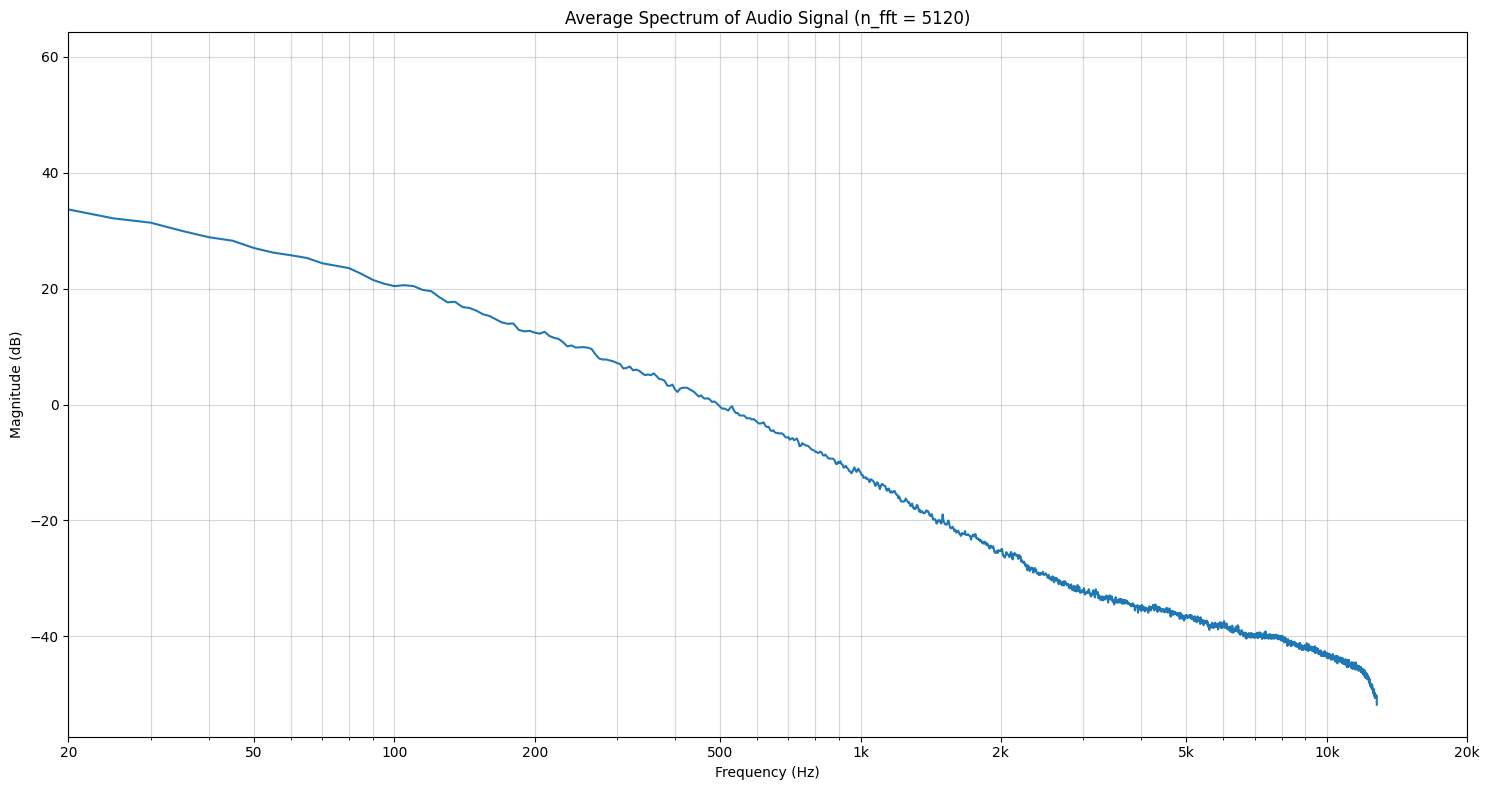

STFT窗口大小: 5120
音頻採樣率: 25600 Hz
時間分辨率: 0.200 秒
音頻長度: 29.25 秒


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import windows
from scipy.fft import rfft

def stft(x, n_fft, hop_length, window):
    num_frames = 1 + (len(x) - n_fft) // hop_length
    frames = np.lib.stride_tricks.as_strided(x, shape=(n_fft, num_frames),
                                             strides=(x.itemsize, hop_length*x.itemsize))
    return rfft(frames * window[:, None], n=n_fft, axis=0)

# 讀取音頻文件
audio_data, sample_rate  = loaded_files[0]

# 確保音頻數據是單聲道的
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# 設置STFT參數
n_fft = sample_rate // 5
hop_length = n_fft // 4  # 75% 重疊

# 應用漢寧窗
window = windows.hann(n_fft, sym=False)

# 執行STFT
stft_result = stft(audio_data, n_fft, hop_length, window)

# 計算平均頻譜
avg_spectrum = np.mean(np.abs(stft_result), axis=1)

# 轉換為分貝
spectrum_db = 20 * np.log10(avg_spectrum + 1e-10)  # 添加小量以避免log(0)

# 創建頻率軸
freqs = np.linspace(0, sample_rate/2, len(spectrum_db))

# 計算頻率分辨率
freq_resolution = sample_rate / n_fft
print(f"頻率分辨率: {freq_resolution:.2f} Hz")

# 繪製頻譜結果
plt.figure(figsize=(15, 8))
plt.semilogx(freqs, spectrum_db)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title(f'Average Spectrum of Audio Signal (n_fft = {n_fft})')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.xlim(20, sample_rate/2)  # 限制x軸範圍從20Hz到Nyquist頻率

# 設置x軸刻度
plt.xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], 
           ['20', '50', '100', '200', '500', '1k', '2k', '5k', '10k', '20k'])

# 添加次要刻度
plt.gca().xaxis.set_minor_locator(plt.LogLocator(subs=np.arange(2, 10) * .1, numticks=100))

plt.tight_layout()
plt.savefig('average_spectrum.png')
plt.show()

# 打印一些有用的信息
print(f"STFT窗口大小: {n_fft}")
print(f"音頻採樣率: {sample_rate} Hz")
print(f"時間分辨率: {n_fft/sample_rate:.3f} 秒")
print(f"音頻長度: {len(audio_data)/sample_rate:.2f} 秒")

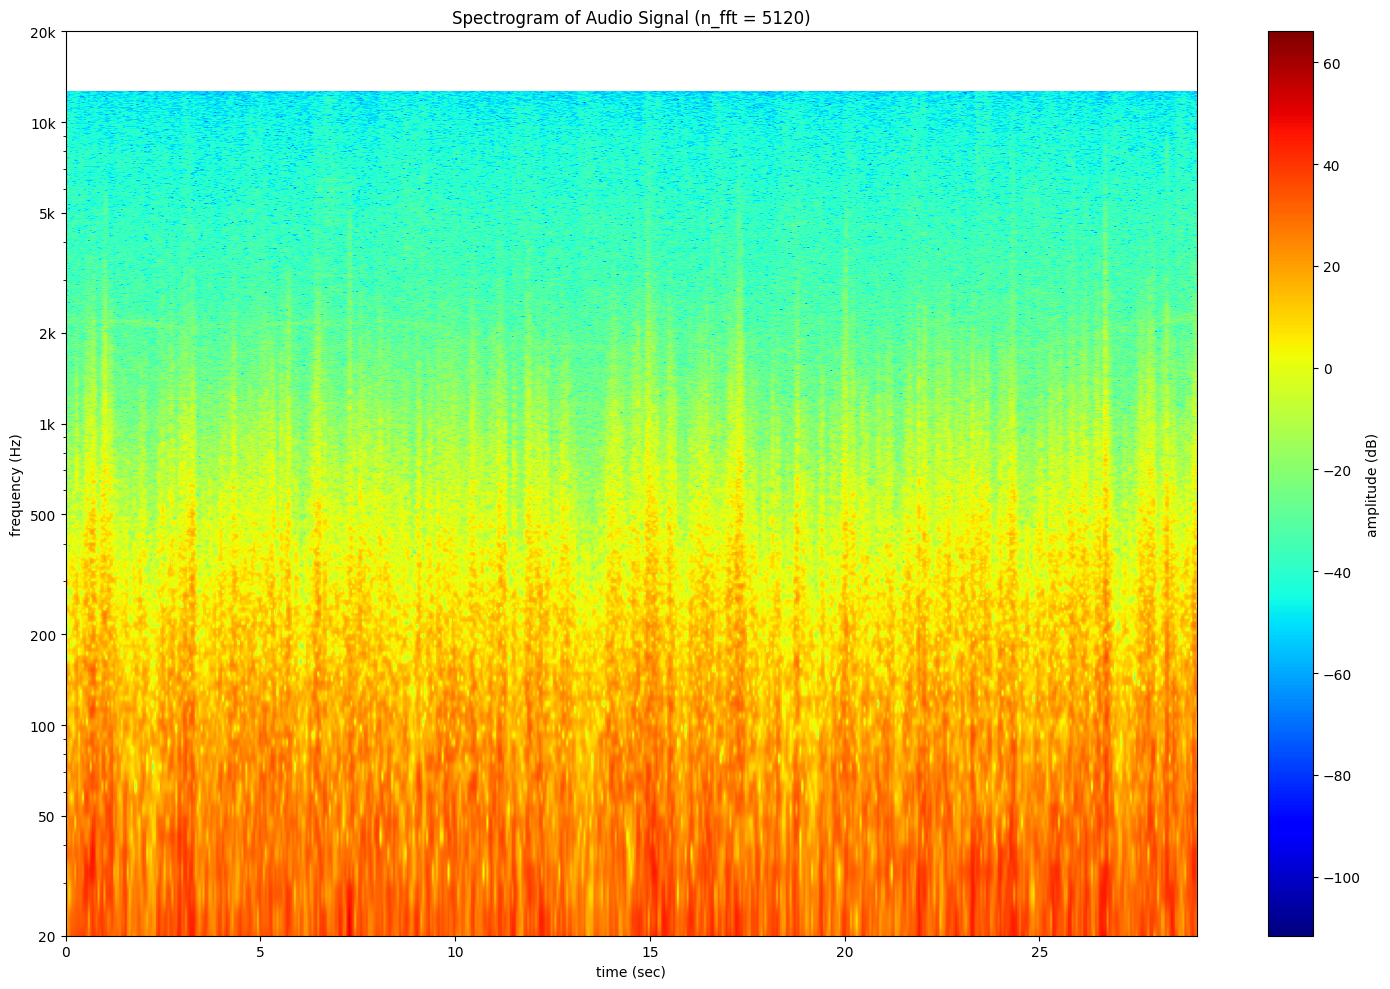

STFT窗口大小: 5120
音頻採樣率: 25600 Hz
時間分辨率: 0.050 秒
頻率分辨率: 5.00 Hz
音頻長度: 29.25 秒


In [68]:
def stft(x, n_fft, hop_length, window):
    num_frames = 1 + (len(x) - n_fft) // hop_length
    frames = np.lib.stride_tricks.as_strided(x, shape=(n_fft, num_frames),
                                             strides=(x.itemsize, hop_length*x.itemsize))
    return rfft(frames * window[:, None], n=n_fft, axis=0)

# 讀取音頻文件
audio_data, sample_rate  = loaded_files[0]

# 確保音頻數據是單聲道的
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# 設置STFT參數
n_fft = sample_rate // 5
hop_length = n_fft // 4  # 75% 重疊

# 應用漢寧窗
window = windows.hann(n_fft, sym=False)

# 執行STFT
stft_result = stft(audio_data, n_fft, hop_length, window)

# 計算頻譜圖（幅度譜）
spectrogram = np.abs(stft_result)

# 轉換為分貝刻度
spectrogram_db = 20 * np.log10(spectrogram + 1e-10)

# 創建時間軸和頻率軸
time = np.arange(spectrogram.shape[1]) * hop_length / sample_rate
freq = np.linspace(0, sample_rate/2, spectrogram.shape[0])

# 繪製頻譜圖
plt.figure(figsize=(15, 10))
plt.imshow(spectrogram_db, aspect='auto', origin='lower', 
           extent=[time.min(), time.max(), freq.min(), freq.max()],
           cmap='jet')

plt.colorbar(label='amplitude (dB)')
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title(f'Spectrogram of Audio Signal (n_fft = {n_fft})')

# 設置y軸為對數刻度
plt.yscale('log')
plt.ylim(20, sample_rate/2)  # 限制y軸範圍從20Hz到奈奎斯特頻率

# 設置y軸刻度
plt.yticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000], 
           ['20', '50', '100', '200', '500', '1k', '2k', '5k', '10k', '20k'])

plt.tight_layout()
plt.savefig('spectrogram.png')
plt.show()

# 打印一些有用的信息
print(f"STFT窗口大小: {n_fft}")
print(f"音頻採樣率: {sample_rate} Hz")
print(f"時間分辨率: {hop_length/sample_rate:.3f} 秒")
print(f"頻率分辨率: {sample_rate / n_fft:.2f} Hz")
print(f"音頻長度: {len(audio_data)/sample_rate:.2f} 秒")

In [6]:
display.Audio(loaded_files[0][0], rate=loaded_files[0][1])


# Resample WAV files
## 重採樣 WAV 檔案

# 繪製梅爾頻譜圖

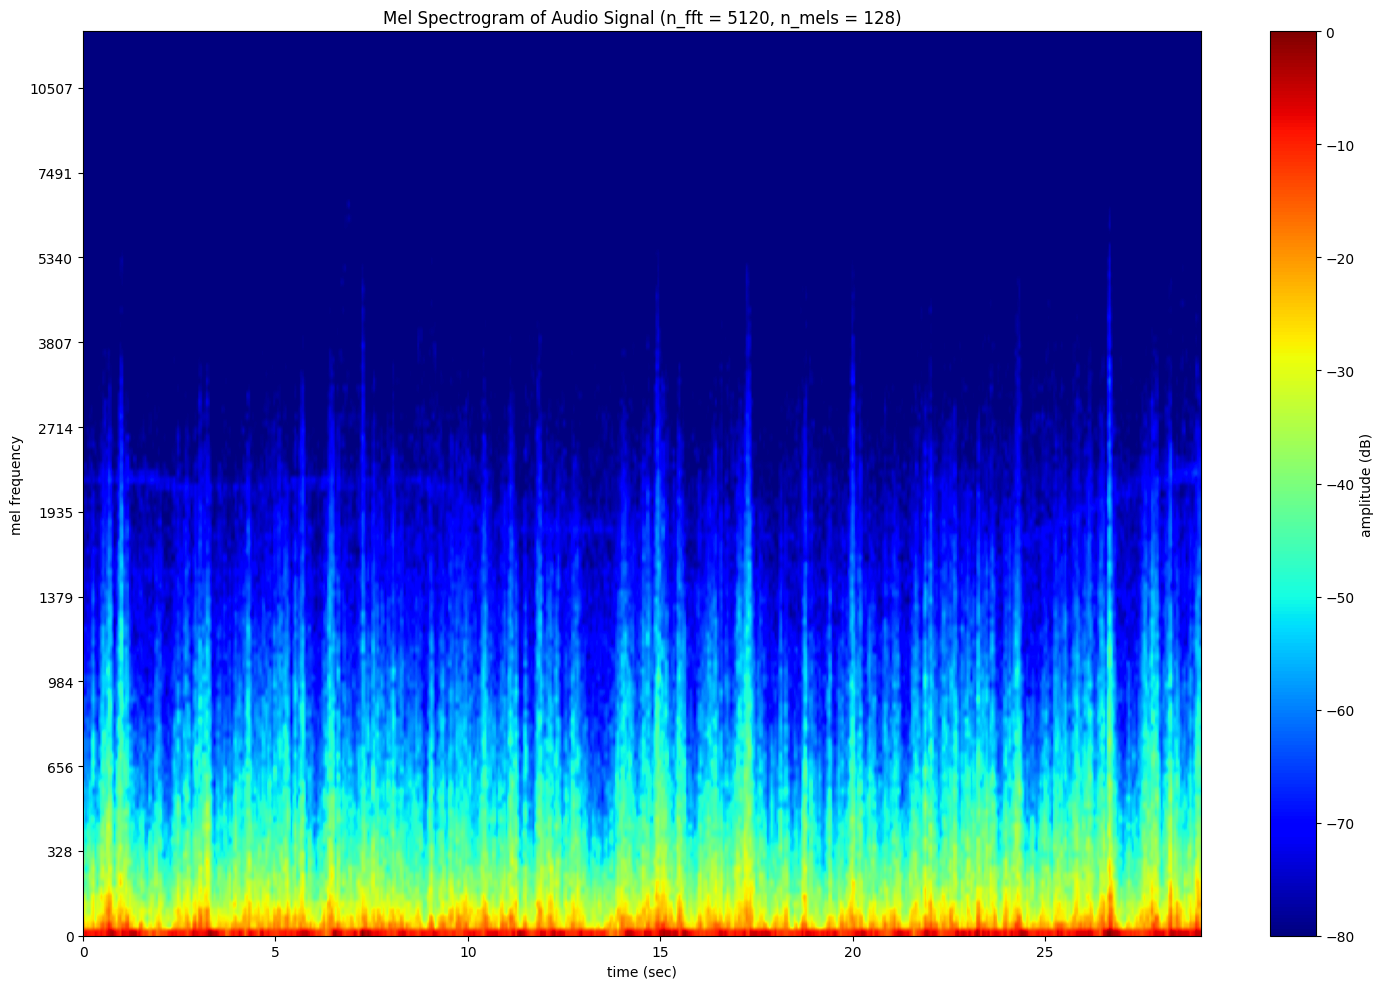

STFT窗口大小: 5120
音頻採樣率: 25600 Hz
時間分辨率: 0.050 秒
梅爾濾波器數量: 128
音頻長度: 29.25 秒


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import windows
from scipy.fft import rfft
import librosa

def stft(x, n_fft, hop_length, window):
    num_frames = 1 + (len(x) - n_fft) // hop_length
    frames = np.lib.stride_tricks.as_strided(x, shape=(n_fft, num_frames),
                                             strides=(x.itemsize, hop_length*x.itemsize))
    return rfft(frames * window[:, None], n=n_fft, axis=0)

# 讀取音頻文件
audio_data, sample_rate  = loaded_files[0]

# 確保音頻數據是單聲道的
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# 將音頻數據轉換為浮點型並歸一化
if audio_data.dtype.kind in 'iu':
    audio_data = audio_data.astype(np.float32) / np.iinfo(audio_data.dtype).max
elif audio_data.dtype.kind == 'f':
    audio_data = audio_data.astype(np.float32)
    max_value = np.max(np.abs(audio_data))
    if max_value > 1.0:
        audio_data /= max_value

# 設置STFT參數
n_fft = sample_rate // 5
hop_length = n_fft // 4  # 75% 重疊

# 應用漢寧窗
window = windows.hann(n_fft, sym=False)

# 執行STFT
stft_result = stft(audio_data, n_fft, hop_length, window)

# 計算功率譜
power_spectrum = np.abs(stft_result) ** 2

# 創建梅爾濾波器組
n_mels = 128
mel_filterbank = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels)

# 將功率譜轉換為梅爾頻譜
mel_spectrogram = np.dot(mel_filterbank, power_spectrum)

# 轉換為分貝刻度
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# 創建時間軸
time = np.arange(mel_spectrogram.shape[1]) * hop_length / sample_rate

# 繪製梅爾頻譜圖
plt.figure(figsize=(15, 10))
plt.imshow(mel_spectrogram_db, aspect='auto', origin='lower', 
           extent=[time.min(), time.max(), 0, n_mels],
           cmap='jet')

plt.colorbar(label='amplitude (dB)')
plt.xlabel('time (sec)')
plt.ylabel('mel frequency')
plt.title(f'Mel Spectrogram of Audio Signal (n_fft = {n_fft}, n_mels = {n_mels})')

# 設置y軸刻度
mel_ticks = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sample_rate/2)
plt.yticks(np.arange(0, n_mels, n_mels//10), 
           [f'{int(f)}' for f in mel_ticks[::n_mels//10]])

plt.tight_layout()
plt.show()

# 打印一些有用的信息
print(f"STFT窗口大小: {n_fft}")
print(f"音頻採樣率: {sample_rate} Hz")
print(f"時間分辨率: {hop_length/sample_rate:.3f} 秒")
print(f"梅爾濾波器數量: {n_mels}")
print(f"音頻長度: {len(audio_data)/sample_rate:.2f} 秒")